In [1]:
import glob
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
import random
import matplotlib.pyplot as plt
import datetime
from typing import Union, List, Tuple
import os
import time
from keras.models import Model
from keras.layers import (BatchNormalization, Flatten, Input, Reshape, Dense, MaxPool2D, Conv1D, Concatenate, Activation)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import seaborn as sns

pi = 3.14159265359
maxval = 1e9
minval = 1e-9

2023-02-09 17:36:26.397790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 17:36:26.660926: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-09 17:36:26.668695: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-09 17:36:26.668735: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
train_df = pd.read_csv('train_1Dy.csv',nrows=100000)
test_df = pd.read_csv('test_1Dy.csv',nrows=5000)

In [3]:
def inverse_cot(cota):
    a = np.arctan(1/cota)
    a[np.where(a<0)] = a[np.where(a<0)]+pi
    return a

In [4]:
X_train = train_df.drop(columns=['y-midplane','cotBeta']).values
X_test = test_df.drop(columns=['y-midplane','cotBeta']).values

y_train = inverse_cot(abs(train_df['cotBeta'].values))*2/pi
y_test = inverse_cot(abs(test_df['cotBeta'].values))*2/pi

/tmp/ipykernel_137137/2672626872.py:2: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1/cota)


In [5]:
X_train = X_train.reshape(-1, X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[-1])

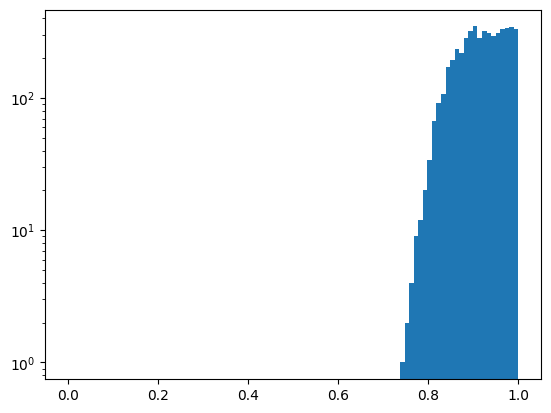

In [6]:
plt.hist(y_test,bins=np.linspace(0,1,100));
plt.yscale('log')

In [7]:
def param_transform(par):
    return minval+tf.math.softplus(par)

def beta_loss(y, p):
    
    alpha = param_transform(tf.gather(params=p, indices=[0], axis=1))
    beta = param_transform(tf.gather(params=p, indices=[1], axis=1))
    
    dist = tfp.distributions.Beta(concentration1 = alpha,
                                  concentration0 = beta)
    
    likelihood = dist.prob(y)  
    likelihood = tf.clip_by_value(likelihood,minval,maxval)

    NLL = -1*tf.math.log(likelihood)
    return tf.keras.backend.sum(NLL,axis=1)    

In [8]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("elu", name="elu1")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense2")(x)
    x = Activation("elu", name="elu2")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense3")(x)
    x = Activation("elu", name="elu3")(x)
    x = BatchNormalization()(x)
    x = Dense(2, name="dense4")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=beta_loss)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                896       
                                                                 
 elu1 (Activation)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense2 (Dense)              (None, 64)                4160      
                                                                 


2023-02-09 17:36:47.776179: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-09 17:36:47.776266: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-09 17:36:47.776309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-jennetd): /proc/driver/nvidia/version does not exist
2023-02-09 17:36:47.776820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 elu2 (Activation)           (None, 64)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense3 (Dense)              (None, 64)                4160      
                                                                 
 elu3 (Activation)           (None, 64)                0         
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense4 (Dense)              (None, 2)                 130       
                                                                 
Total params: 10,114
Trainable params: 9,730
Non-trainable params: 384
_____

In [9]:
es = EarlyStopping(patience=20,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=1000, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/1000
1250/1250 [==============================] - 10s 6ms/step - loss: -1.5741 - val_loss: -2.0497
Epoch 2/1000
1250/1250 [==============================] - 6s 5ms/step - loss: -2.1382 - val_loss: -2.2255
Epoch 3/1000
1250/1250 [==============================] - 6s 5ms/step - loss: -2.2407 - val_loss: -2.2821
Epoch 4/1000
1250/1250 [==============================] - 6s 5ms/step - loss: -2.2890 - val_loss: -2.3108
Epoch 5/1000
1250/1250 [==============================] - 6s 5ms/step - loss: -2.3248 - val_loss: -2.3644
Epoch 6/1000
1250/1250 [==============================] - 6s 5ms/step - loss: -2.3471 - val_loss: -2.3557
Epoch 7/1000
1250/1250 [==============================] - 7s 5ms/step - loss: -2.3684 - val_loss: -2.3860
Epoch 8/1000
1250/1250 [==============================] - 7s 5ms/step - loss: -2.3658 - val_loss: -2.3967
Epoch 9/1000
1250/1250 [==============================] - 7s 5ms/step - loss: -2.3856 - val_loss: -2.3235
Epoch 10/1000
1250/1250 [====================

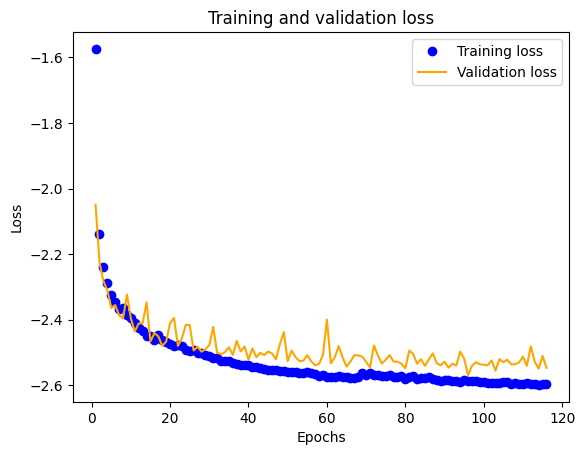

In [10]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('Log')
plt.legend()
plt.show()

In [28]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['par1','par2'])
df['Btrue'] = y_test*pi/2
df['alpha'] = param_transform(df['par1'])
df['beta'] = param_transform(df['par2'])

dist = tfp.distributions.Beta(concentration1 = df['alpha'], concentration0 = df['beta'])
    
df['mean'] = dist.mean()*pi/2
df['mode'] = dist.mode()*pi/2
df['sigma'] = dist.stddev()*pi/2

df.to_csv("test_1DcotBBeta.csv",header=False,index=False)

157/157 [==============================] - 0s 2ms/step


In [12]:
residuals = df['Btrue'] - df['mode']
print(np.mean(residuals),np.std(residuals))

-0.012950653092771706 0.034548317700981886


/tmp/ipykernel_137137/504458315.py:2: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


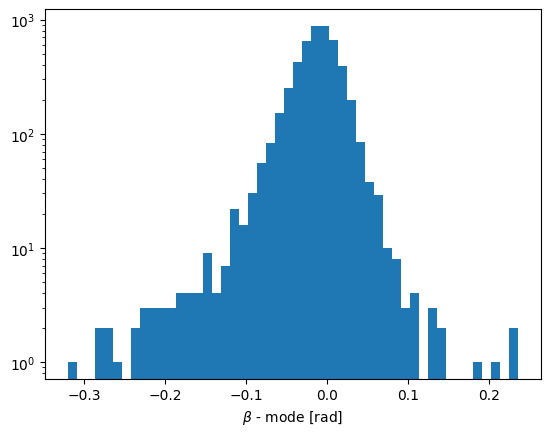

/tmp/ipykernel_137137/504458315.py:7: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


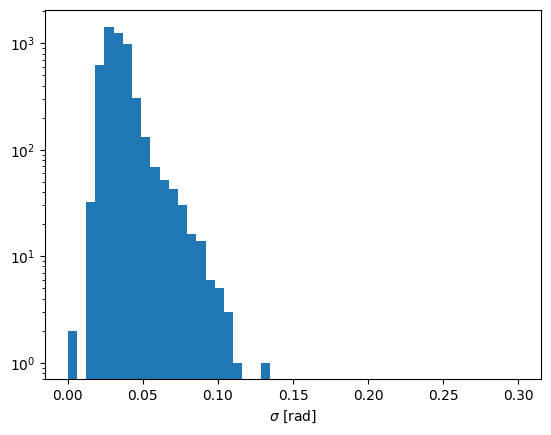

/tmp/ipykernel_137137/504458315.py:12: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


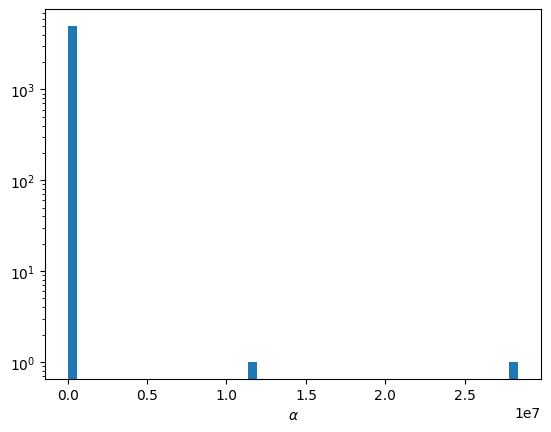

/tmp/ipykernel_137137/504458315.py:17: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


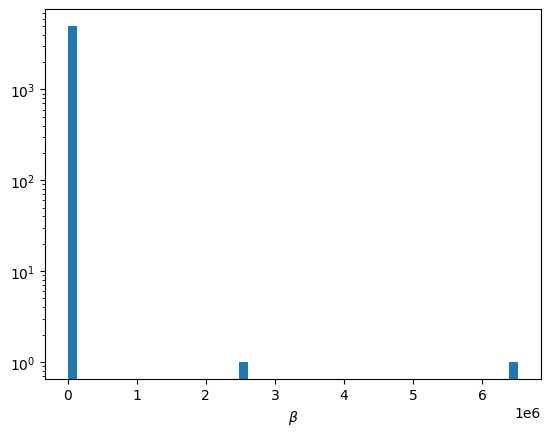

In [13]:
plt.hist(residuals,bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$ - mode [rad]')
plt.show()

plt.hist(df['sigma'],bins=np.linspace(0,0.3,50));
plt.yscale('Log')
plt.xlabel(r'$\sigma$ [rad]')
plt.show()

plt.hist(df['alpha'],bins=50)
plt.yscale('Log')
plt.xlabel(r'$\alpha$')
plt.show()

plt.hist(df['beta'],bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$')
plt.show()

/tmp/ipykernel_137137/2827940454.py:2: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


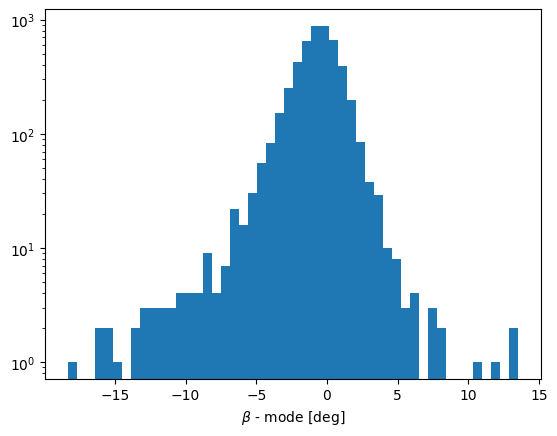

/tmp/ipykernel_137137/2827940454.py:7: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


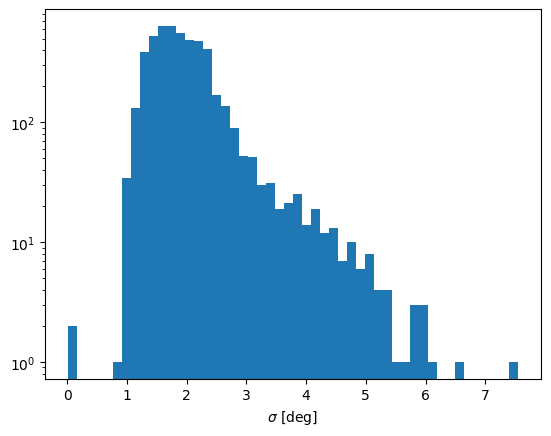

In [14]:
plt.hist(residuals*180/pi,bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$ - mode [deg]')
plt.show()

plt.hist(df['sigma']*180/pi,bins=50);
plt.yscale('Log')
plt.xlabel(r'$\sigma$ [deg]')
plt.show()

Text(0, 0.5, 'log(beta)')

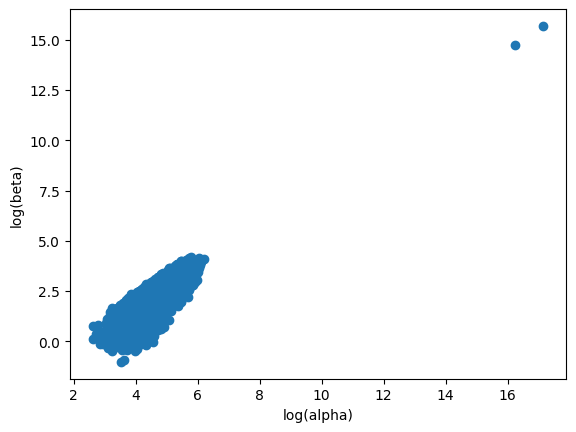

In [15]:
plt.scatter(np.log(df['alpha']),np.log(df['beta']))
plt.xlabel('log(alpha)')
plt.ylabel('log(beta)')

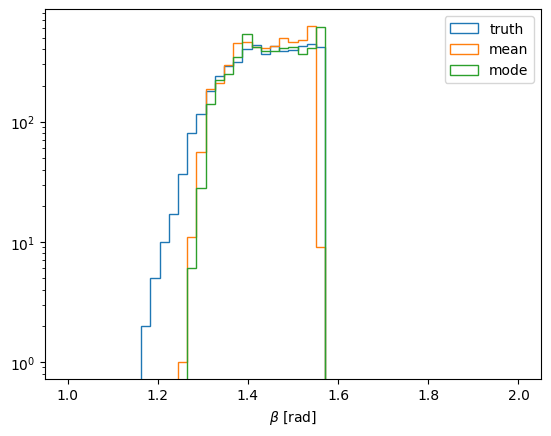

In [16]:
plt.hist(df['Btrue'],bins=np.linspace(1,2,50),histtype='step',label='truth')
plt.hist(df['mean'],bins=np.linspace(1,2,50),histtype='step',label='mean')
plt.hist(df['mode'],bins=np.linspace(1,2,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\beta$ [rad]')
plt.legend()
plt.yscale('log')
plt.show()

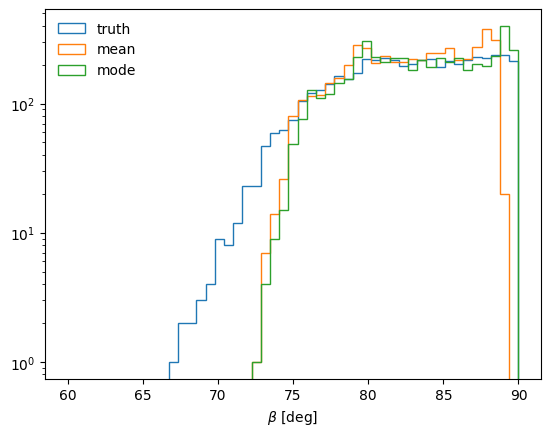

In [17]:
plt.hist(df['Btrue']*180/pi,bins=np.linspace(60,90,50),histtype='step',label='truth')
plt.hist(df['mean']*180/pi,bins=np.linspace(60,90,50),histtype='step',label='mean')
plt.hist(df['mode']*180/pi,bins=np.linspace(60,90,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\beta$ [deg]')
plt.legend(frameon=False,loc='upper left')
plt.yscale('log')
plt.show()

Text(0, 0.5, '$\\beta$ - mode [rad]')

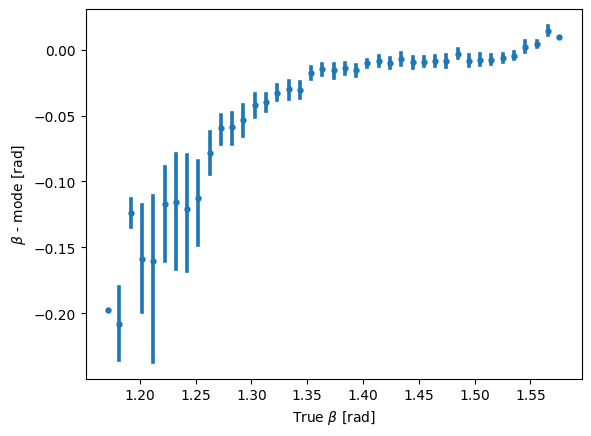

In [18]:
x = sns.regplot(x=df['Btrue'], y=df['Btrue']-df['mode'], x_bins=np.linspace(1,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [rad]')
plt.ylabel(r'$\beta$ - mode [rad]')

Text(0, 0.5, '$\\beta$ - mode [deg]')

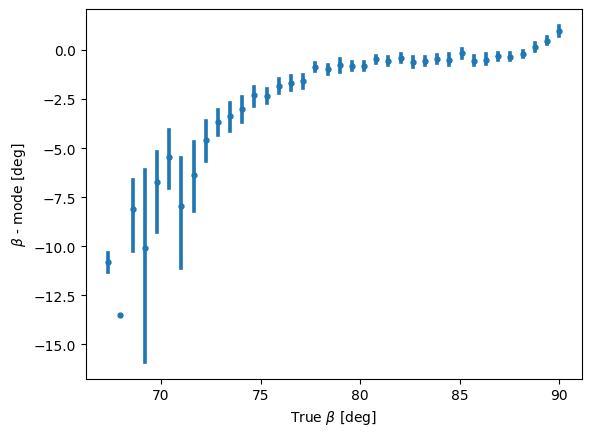

In [19]:
x = sns.regplot(x=df['Btrue']*180/pi, y=(df['Btrue']-df['mode'])*180/pi, x_bins=np.linspace(60,90,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [deg]')
plt.ylabel(r'$\beta$ - mode [deg]')

Text(0, 0.5, '$\\beta$ - mode [rad]')

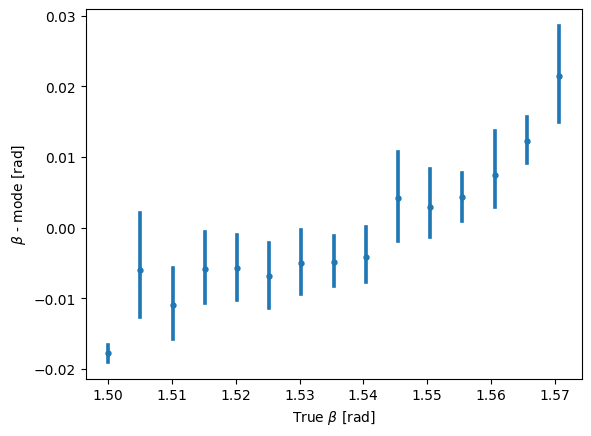

In [20]:
x = sns.regplot(x=df['Btrue'], y=df['Btrue']-df['mode'], x_bins=np.linspace(1.5,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [rad]')
plt.ylabel(r'$\beta$ - mode [rad]')

Text(0, 0.5, '$\\beta$ - mode [deg]')

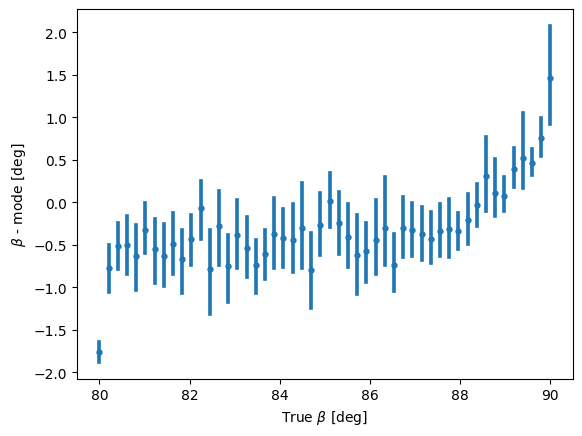

In [21]:
x = sns.regplot(x=df['Btrue']*180/pi, y=(df['Btrue']-df['mode'])*180/pi, x_bins=np.linspace(80,90,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [deg]')
plt.ylabel(r'$\beta$ - mode [deg]')

Text(0, 0.5, '$\\sigma$ [rad]')

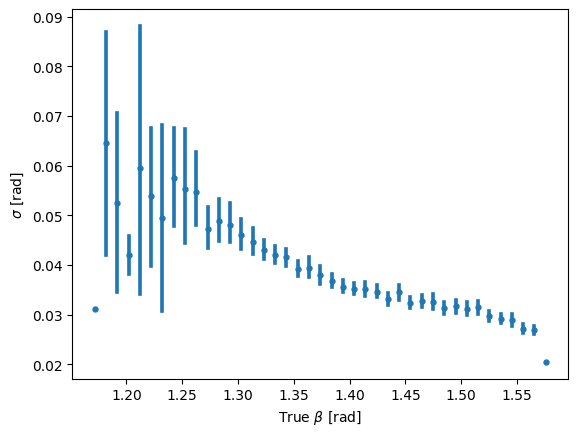

In [22]:
y = sns.regplot(x=df['Btrue'], y=df['sigma'], x_bins=np.linspace(1,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [rad]')
plt.ylabel(r'$\sigma$ [rad]')

Text(0, 0.5, '$\\sigma$ [deg]')

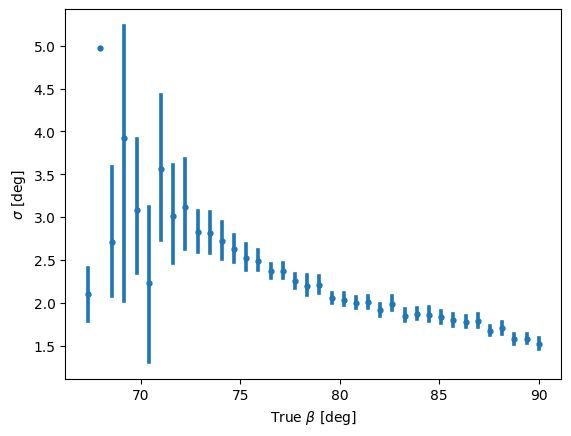

In [23]:
y = sns.regplot(x=df['Btrue']*180/pi, y=df['sigma']*180/pi, x_bins=np.linspace(60,90,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [deg]')
plt.ylabel(r'$\sigma$ [deg]')

In [24]:
pulls = residuals/df['sigma']

Text(0.5, 0, 'pull')

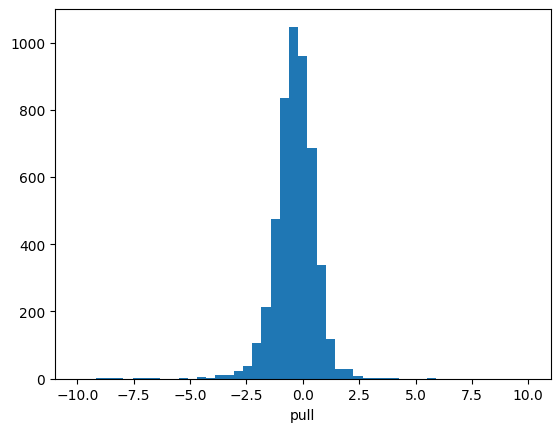

In [25]:
plt.hist(pulls,bins=np.linspace(-10,10,50));
plt.xlabel('pull')

In [26]:
print(np.mean(pulls),np.std(pulls))

0.03891240193324879 31.83248032496584
